# Modeling #

## Import APIs ##

In [1]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

import wfdb
import ast

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Load data ##

### Metadata ###

In [4]:
ptbxl_df = pd.read_csv('./cleaned_data/cleaned_ptbxl_metadata.csv', index_col='ecg_id')
metadata = ptbxl_df.loc[:, ['age', 'sex', 'device', 'validated_by_human']].copy()
metadata.head()

,age,sex,device,validated_by_human
ecg_id,,,,
1,56.0,1,CS-12 E,True
2,19.0,0,CS-12 E,True
3,37.0,1,CS-12 E,True
4,24.0,0,CS-12 E,True
5,19.0,1,CS-12 E,True


### Waveform data ###

In [5]:
waveform_data = []
for idx in ptbxl_df.index:
    record_path = ptbxl_df.loc[idx]['filename_hr']
    waveform_df = pd.read_csv('./cleaned_data/waveform_data/' + record_path + '.csv', index_col='Time (s)')
    waveform_data.append(waveform_df)
waveform_data = np.array(waveform_data)
waveform_data.shape

(21799, 1000, 12)

In [5]:
# waveform_data = np.load("./cleaned_data/waveform_np.npy")

## Create recommended train-test split ##

This recommended train-test split code was obtained from the downloaded folder with the dataset: https://physionet.org/content/ptb-xl/1.0.3/.

In [6]:
# Split data into train and test
test_fold = 10

# Train
waveform_train = waveform_data[np.where(ptbxl_df.strat_fold != test_fold)]
metadata_train = metadata[ptbxl_df.strat_fold != test_fold]
y_train = ptbxl_df[ptbxl_df.strat_fold != test_fold].diagnostic_superclass

# Test
waveform_test = waveform_data[np.where(ptbxl_df.strat_fold == test_fold)]
metadata_test = metadata[ptbxl_df.strat_fold == test_fold]
y_test = ptbxl_df[ptbxl_df.strat_fold == test_fold].diagnostic_superclass

## Normalize waveform data ##

In [34]:
def normalize_waveform(data):
    # Code generated from Bing Copilot
    normalized_data = np.empty_like(data)
    for i in range(data.shape[0]):
        for j in range(data.shape[2]):
            min_val = np.min(data[i, :, j])
            max_val = np.max(data[i, :, j])

            if max_val == min_val:
                normalized_data[i, :, j] = 0
            else:
                normalized_data[i, :, j] = (data[i, :, j] - min_val) / (max_val - min_val)
    return normalized_data

In [35]:
# Since normalization occurs only within each record, there will be no contamination from train data
normalized_waveform_train = normalize_waveform(waveform_train)
normalized_waveform_test = normalize_waveform(waveform_test)

## Normalize and one-hot encode metadata ##

In [37]:
# Code generated from ChatGPT
scaler_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

encoder_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', scaler_transformer, ['age']),
        ('cat', encoder_transformer, ['sex', 'device', 'validated_by_human'])
    ])

normalized_metadata_train = preprocessor.fit_transform(metadata_train).toarray()
normalized_metadata_test = preprocessor.transform(metadata_test).toarray()

## Initialize Dataloaders ##

In [47]:
waveform_train_set = torch.from_numpy(normalized_waveform_train).float()
waveform_test_set = torch.from_numpy(normalized_waveform_test).float()

metadata_train_set = torch.from_numpy(normalized_metadata_train).float()
metadata_test_set = torch.from_numpy(normalized_metadata_test).float()

In [40]:
batch_size = 32

train_dataset = TensorDataset(waveform_train_set, metadata_train_set)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(waveform_test_set, metadata_test_set)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

## CNN autoencoder + LSTM metadata model ##

In [277]:
class CNNAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv1d(in_channels=12,
                      out_channels=64,
                      kernel_size=4,
                      stride=1),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(in_channels=64,
                               out_channels=12,
                               kernel_size=4,
                               stride=1),
            nn.Sigmoid(),
            nn.Upsample(1000)
        )
    
    def forward(self, x):
        x = x.permute(0, 2, 1)
        encoded_output = self.encoder(x)
        decoded_output = self.decoder(encoded_output)
        return decoded_output.permute(0, 2, 1)

In [278]:
class MetadataLSTM(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(16, 64, batch_first=True)
        self.output_layer = nn.Linear(64, 12)
    
    def forward(self, x, h):
        lstm_outputs, h_n = self.lstm(x, h)
        outputs = self.output_layer(lstm_outputs.squeeze(dim=1))
        return outputs, h_n

In [279]:
class CombinedModel(nn.Module):
    def __init__(self, cnn_autoencoder, lstm_model):
        super().__init__()
        self.cnn_autoencoder = cnn_autoencoder
        self.lstm_model = lstm_model
        self.fc = nn.Linear(24, 12)
        
    def forward(self, ecg_data, metadata, hc):
        cnn_output = self.cnn_autoencoder(ecg_data)
        lstm_output, hc_n = self.lstm_model(metadata, hc)
        reshaped_lstm_output = lstm_output.unsqueeze(1).repeat(1, 1000, 1)
        combined_output = torch.cat((cnn_output, reshaped_lstm_output), dim=-1)
        output = self.fc(combined_output)

        return output, hc_n

### Training ###

In [285]:
cnn_autoencoder_model = CNNAutoencoder()
lstm_metadata_model = MetadataLSTM()

combinedModel = CombinedModel(cnn_autoencoder_model, lstm_metadata_model)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(combinedModel.parameters(), lr=1e-3)

combinedModel.to(device)

CombinedModel(
  (cnn_autoencoder): CNNAutoencoder(
    (encoder): Sequential(
      (0): Conv1d(12, 64, kernel_size=(4,), stride=(1,))
      (1): ReLU()
    )
    (decoder): Sequential(
      (0): ConvTranspose1d(64, 12, kernel_size=(4,), stride=(1,))
      (1): Sigmoid()
      (2): Upsample(size=1000, mode='nearest')
    )
  )
  (lstm_model): MetadataLSTM(
    (lstm): LSTM(16, 64, batch_first=True)
    (output_layer): Linear(in_features=64, out_features=12, bias=True)
  )
  (fc): Linear(in_features=24, out_features=12, bias=True)
)

In [286]:
def train_combined(model, train_loader, criterion, optimizer, nepoch=10):
    for epoch in range(nepoch):
        num_layers = model.lstm_model.lstm.num_layers
        hidden_size = model.lstm_model.lstm.hidden_size
        h_0 = torch.zeros(num_layers, hidden_size).to(device)
        c_0 = torch.zeros(num_layers, hidden_size).to(device)
        for batch_ecg, batch_metadata in train_loader:
            ecg_data = batch_ecg.to(device).float()
            metadata = batch_metadata.to(device).float()
            
            optimizer.zero_grad()
            reconstructed_data, (h_n, c_n) = model(ecg_data, metadata, (h_0, c_0))
            loss = criterion(reconstructed_data, ecg_data)
            loss.backward()
            optimizer.step()
        
        print(f"Epoch [{epoch+1}/{nepoch}], Loss: {loss.item()}")
            

In [287]:
# Train the model
train_combined(combinedModel, train_loader, criterion, optimizer)

Epoch [1/15], Loss: 0.005077878944575787
Epoch [2/15], Loss: 0.001531979301944375
Epoch [3/15], Loss: 0.001529518747702241
Epoch [4/15], Loss: 0.0010737107368186116
Epoch [5/15], Loss: 0.0011238170554861426
Epoch [6/15], Loss: 0.0005230715032666922
Epoch [7/15], Loss: 0.0006222517695277929
Epoch [8/15], Loss: 0.0005992514779791236
Epoch [9/15], Loss: 0.0003138993342872709
Epoch [10/15], Loss: 0.0001873514847829938
Epoch [11/15], Loss: 0.00041470254654996097
Epoch [12/15], Loss: 0.00027180384495295584
Epoch [13/15], Loss: 0.000428893108619377
Epoch [14/15], Loss: 0.0002004594571189955
Epoch [15/15], Loss: 0.00021713196474593133


In [22]:
torch.save(combinedModel.state_dict(), "./models/combinedModel.pth")

### Visualization ###

In [333]:
def visualize_predictions(model, ecg_input, metadata_input):
    lead_vals = ['I', 'II', 'III', 'AVR', 'AVL', 'AVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
    time = np.arange(0, 1000) / 100
    
    num_layers = model.lstm_model.lstm.num_layers
    hidden_size = model.lstm_model.lstm.hidden_size
    h_0 = torch.zeros(num_layers, hidden_size).to(device)
    c_0 = torch.zeros(num_layers, hidden_size).to(device)
    
    prediction, _ = model(ecg_input, metadata_input, (h_0, c_0))
    fig, axs = plt.subplots(6, 2, figsize=(15, 20))
    for i in range(6):
        for j in range(2):
            lead_idx = i * 2 + j
            lead_val = lead_vals[lead_idx]
            
            original_ecg = ecg_input[0, :, lead_idx].detach().numpy()
            reconstructed_ecg = prediction[0, :, lead_idx].detach().numpy()
            
            axs[i, j].plot(time, original_ecg, label='Original')
            axs[i, j].plot(time, reconstructed_ecg, label='Reconstructed')
            axs[i, j].set_xlabel('Time (s)')
            axs[i, j].set_ylabel('Normalized ECG Reading')
            axs[i, j].set_title(f'Lead {lead_val}')
            axs[i, j].legend()
    plt.tight_layout()
    plt.show()

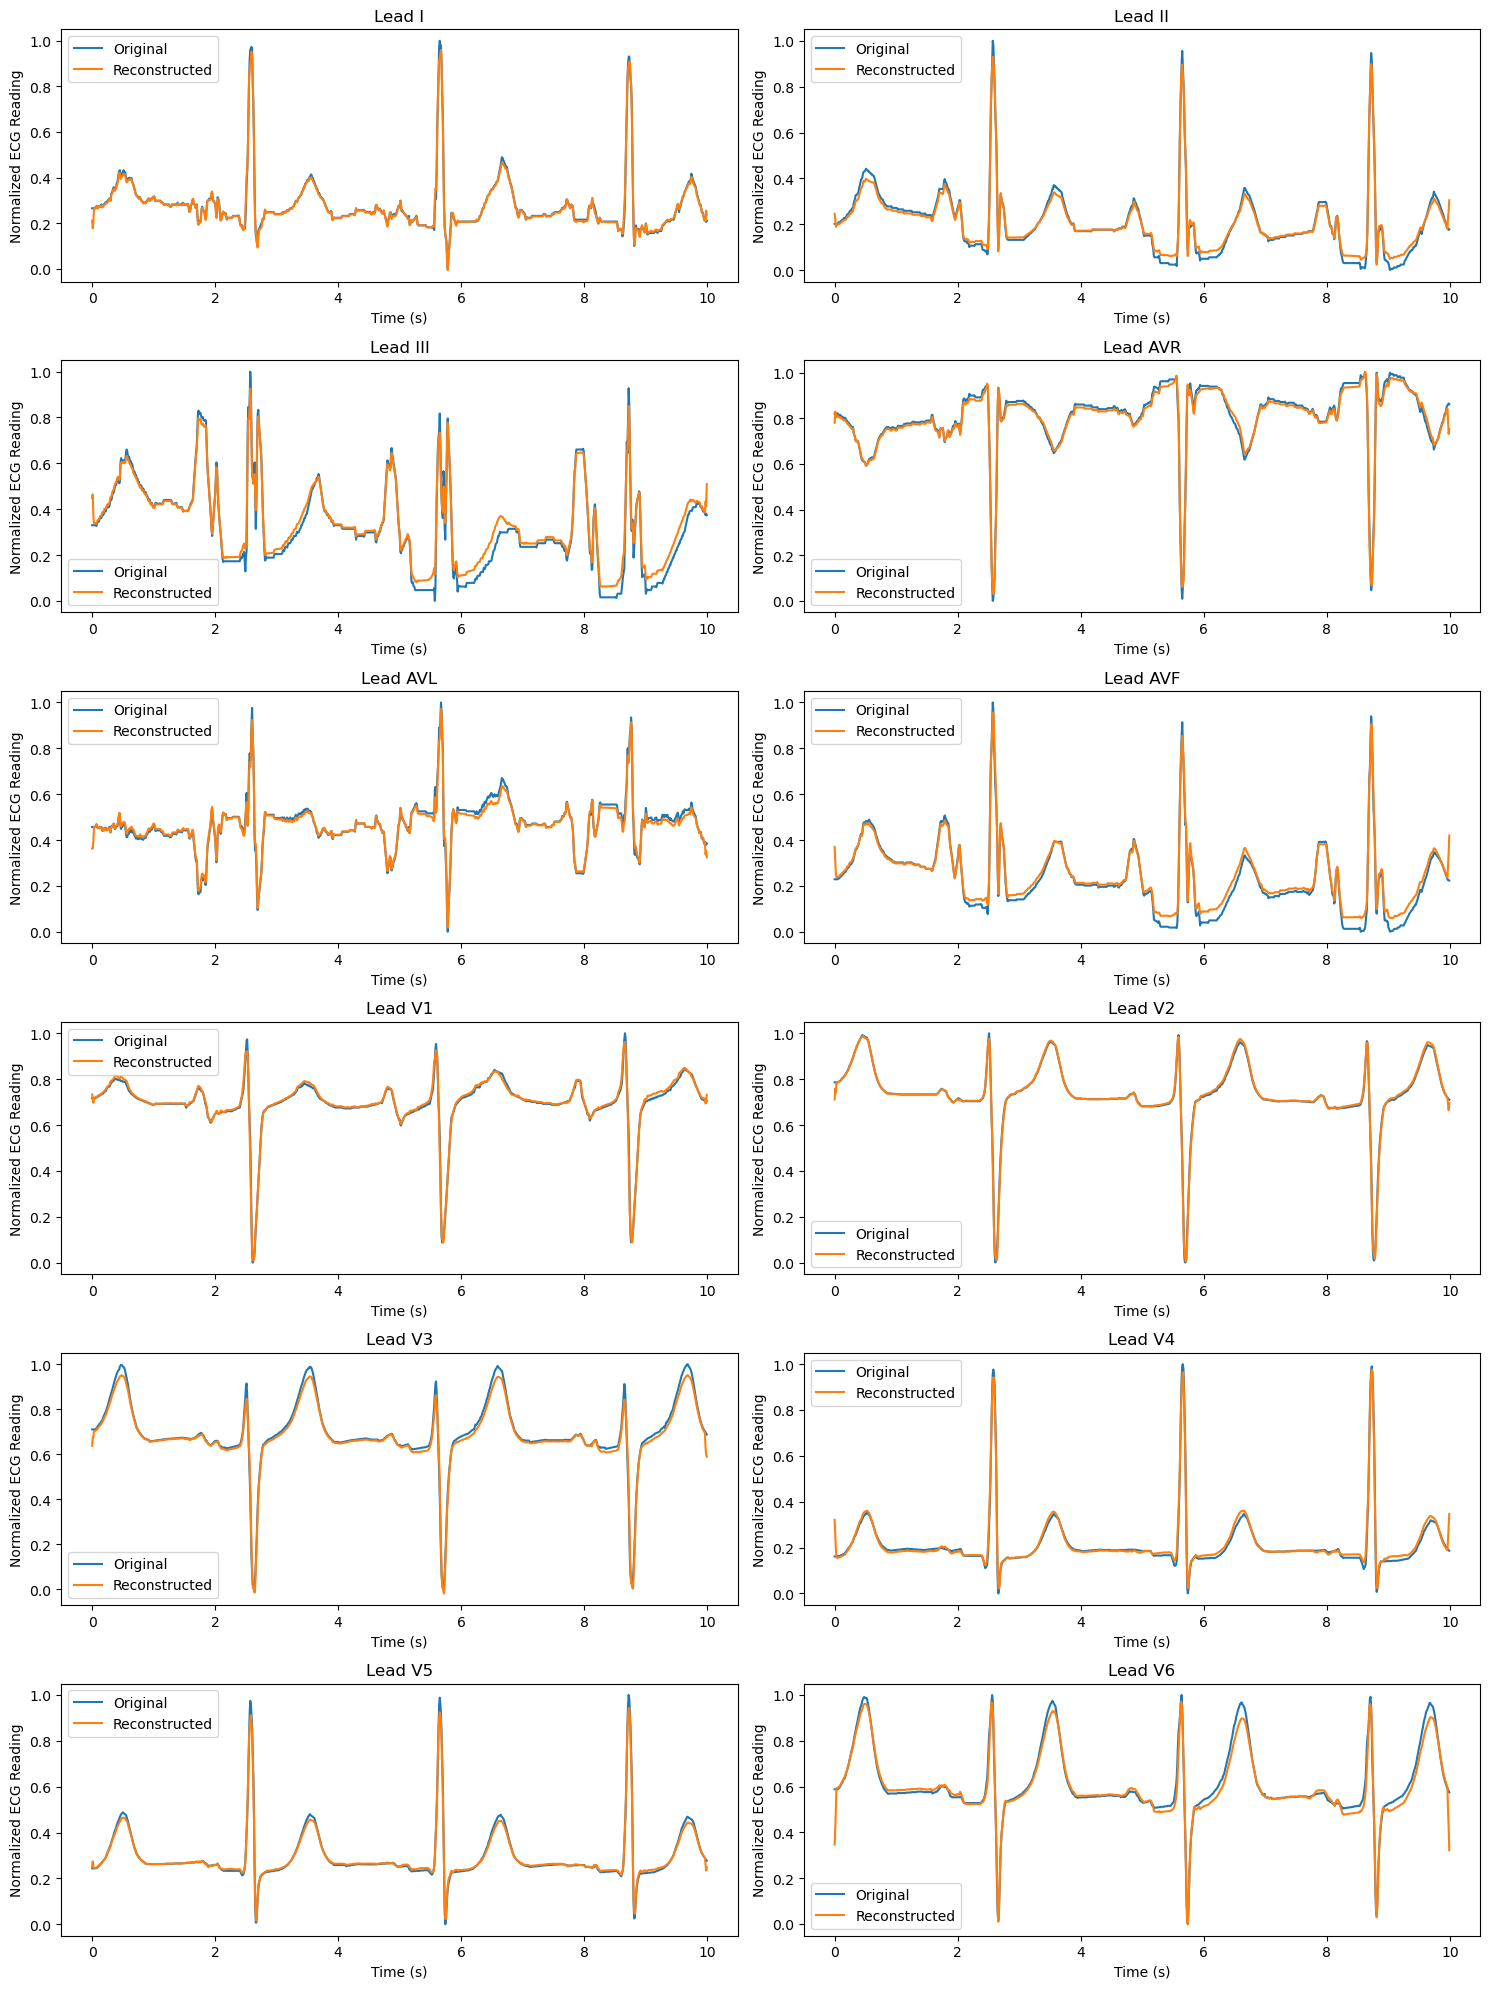

In [334]:
for batch_data, batch_metadata in test_loader:
    ecg_data = batch_data.to(device).float()
    batch_size = ecg_data.size(0)
    batch_metadata = batch_metadata.to(device).float()
    
    single_ecg_data = ecg_data[0].unsqueeze(0)
    single_metadata = batch_metadata[0].unsqueeze(0)
    
    break

visualize_predictions(combinedModel, single_ecg_data, single_metadata)

## TCN Autoencoder ##

Model Card for the Hybrid Autoencoder Model Name: Hybrid Autoencoder for ECG and Metadata

Description: This model is designed to learn compressed representations of combined ECG waveform and patient metadata. It utilizes separate pathways for waveform data and metadata, merging them into a dense representation which is then used to reconstruct both types of data.

Model Architecture:

Waveform Pathway: Convolutional layers followed by pooling and flattening. Metadata Pathway: Dense layers. Combined Encoding and Decoding: Dense layers. Intended Use: Intended for anomaly detection in ECG data where additional patient metadata is available and considered relevant.

Data Used for Training: Assumes a dataset comprising ECG waveform data aligned with patient metadata such as age, sex, and device information.

Limitations: The model's effectiveness is highly dependent on the quality and preprocessing of the input data. The architecture needs fine-tuning and validation using real-world data to ensure robustness.

Ethical Considerations: Care should be taken to avoid biases that may arise from imbalanced data across different demographic groups. Privacy concerns should be addressed when handling patient data.

This framework sets up the foundation of your model; further tuning, training, and validation steps are needed to adapt it to specific tasks or datasets.

In [17]:
num_unique_devices = metadata['device'].nunique()
print(f"Number of unique devices: {num_unique_devices}")

Number of unique devices: 11


In [18]:
from pytorch_tcn import TCN

class TCNAutoencoder(nn.Module):
    def __init__(self, num_inputs, num_channels, kernel_size, dropout, metadata_dims):
        super(TCNAutoencoder, self).__init__()
        self.encoder = TCN(
            num_inputs=num_inputs,
            num_channels=num_channels,
            kernel_size=kernel_size,
            dropout=dropout,
            causal=True,
        )
        self.age_embedding = nn.Linear(1, metadata_dims[0])  # Age is a single value
        self.sex_embedding = nn.Linear(2, metadata_dims[1])  # Sex is one-hot encoded (2 columns)
        self.device_embedding = nn.Linear(num_unique_devices, metadata_dims[2]) #one hot (11 cols)
        self.validated_embedding = nn.Linear(2, metadata_dims[3]) #one hot (2 cols)
        
        decoder_input_dim = num_channels[-1] + sum(metadata_dims)
        self.decoder = TCN(
            num_inputs=decoder_input_dim,
            num_channels=num_channels[::-1],
            kernel_size=kernel_size,
            dropout=dropout,    
            causal=True,
            output_projection=num_inputs,
        )
        
    def forward(self, x, metadata):
        encoded = self.encoder(x)
        
        age_emb = self.age_embedding(metadata[:, 0].unsqueeze(1))
        sex_emb = self.sex_embedding(metadata[:, 1:3])
        device_emb = self.device_embedding(metadata[:, 3:-2])
        validated_emb = self.validated_embedding(metadata[:, -2:])
        
        metadata_emb = torch.cat([age_emb, sex_emb, device_emb, validated_emb], dim=-1)
        metadata_emb = metadata_emb.unsqueeze(2).expand(-1, -1, encoded.size(2))
        
        concatenated = torch.cat([encoded, metadata_emb], dim=1)
        decoded = self.decoder(concatenated)
        return decoded

In [19]:
batch_size = 32
num_inputs = 12  # Assuming 12 input channels in the ECG data
num_channels = [32, 64, 128]  # Example number of channels in each residual block of the encoder
kernel_size = 3  # Example kernel size for the TCN layers
dropout = 0.2  # Example dropout rate
metadata_dims = [10, 5, 20, 5]  # Example embedding dimensions for age, sex, and device, and validated

num_unique_devices = metadata['device'].nunique()
print(normalized_metadata_train.shape)
assert num_unique_devices == normalized_metadata_train.shape[1] - 5, "Number of unique devices should match the number of device columns in metadata"

model = TCNAutoencoder(num_inputs, num_channels, kernel_size, dropout, metadata_dims)

model.to(device)

train_dataset = TensorDataset(torch.from_numpy(normalized_waveform_train).float(), torch.from_numpy(normalized_metadata_train))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 10

(19601, 16)


In [20]:
for epoch in range(num_epochs):
    for batch_data, batch_metadata in train_loader:
        ecg_data = batch_data.to(device).permute(0, 2, 1).float()
        batch_metadata = batch_metadata.to(device).float()
        
        optimizer.zero_grad()
        reconstructed_data = model(ecg_data, batch_metadata)
        loss = criterion(reconstructed_data, ecg_data)
        loss.backward()
        optimizer.step()
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

Epoch [1/10], Loss: 0.0008
Epoch [2/10], Loss: 0.0001
Epoch [3/10], Loss: 0.0001
Epoch [4/10], Loss: 0.0001
Epoch [5/10], Loss: 0.0001
Epoch [6/10], Loss: 0.0000


KeyboardInterrupt: 

In [13]:
torch.save(model.state_dict(), "./models/tcn.pth")
print(f"Model saved")

Model saved


In [ ]:
#make sure outputs are 1k x 12